In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2001,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
# portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
#                           ,classifier_list.WEEKLY_CRYPTO_FASTSLOW_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)
# portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
#                           ,classifier_list.WEEKLY_CRYPTO_FASTSLOW_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)
# portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
# portfolios.append(portfolio_iv)
# portfolios.append(portfolio_v)
# portfolios.append(portfolio_vi)

In [5]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [6]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [7]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [8]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("trades")
    trade["positions"] = int(portfolio.pricer_class.positions / 5)
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [9]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [10]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [11]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [12]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'portfolio',
 'pricer_timeframe']

In [13]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


In [14]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
955,True,True,False,False,False,1.50,1,5,True,wss_n_n_b_r,week,14.477462,-0.066282,0.777910,-203.320744
955,True,True,False,False,False,1.15,1,5,True,wss_n_n_b_r,week,14.464499,-0.066325,0.777765,-202.992773
955,True,True,False,False,False,2.00,1,5,True,wss_n_n_b_r,week,14.414448,-0.066196,0.778198,-202.631697
955,True,True,False,False,False,3.00,1,5,True,wss_n_n_b_r,week,14.401334,-0.066283,0.777907,-202.169166
1069,True,True,False,False,False,1.15,1,5,True,wsr_n_n_b_r,week,12.344939,0.096042,1.203905,118.114704
1068,True,True,False,False,False,1.15,1,5,True,wsw_n_n_b_r,week,7.407097,0.232820,1.492875,27.515189


In [15]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_n_n_b_r,True,True,False,False,False,1.15,1,5,True,week,12.344939,0.096042,1.203905,118.114704
1,wss_n_n_b_r,True,True,False,False,False,1.50,1,5,True,week,14.477462,-0.066282,0.777910,-203.320744
2,wsw_n_n_b_r,True,True,False,False,False,1.15,1,5,True,week,7.407097,0.232820,1.492875,27.515189


In [16]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

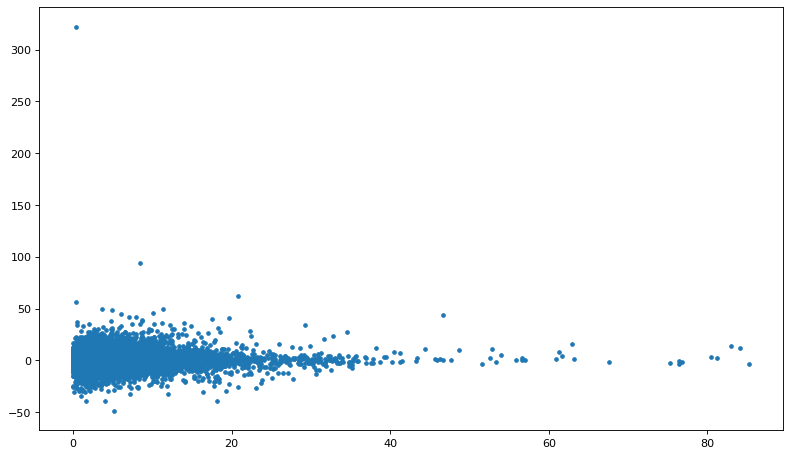

In [17]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [18]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2003,5,ABMD,0.131069,1.0,0.952849,0,Health Care,Abiomed
956,2003,5,BDX,0.043588,1.0,0.951671,1,Health Care,Becton Dickinson
1910,2003,5,PTC,0.039568,1.0,0.945833,2,Information Technology,PTC
2864,2003,5,FCX,0.018587,1.0,1.012273,3,Materials,Freeport-McMoRan
3815,2003,5,RMD,0.014746,1.0,1.023411,4,Health Care,ResMed
4764,2003,5,J,0.011867,1.0,1.005442,5,Industrials,Jacobs Engineering Group
5713,2003,5,IDXX,0.004632,1.0,1.008605,6,Health Care,Idexx Laboratories
6661,2003,5,NEM,0.003383,1.0,1.011202,7,Materials,Newmont
7605,2003,5,WYNN,0.003218,1.0,0.952314,8,Consumer Discretionary,Wynn Resorts
8546,2003,5,NFLX,0.002539,1.0,0.980080,9,Communication Services,Netflix


In [19]:
ledger["actual_returns"].mean()

1.0025707421658683

In [20]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5395944837285619

In [21]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [22]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,2003,5,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2003,6,0.990150,0.942857,1.121875,0.984262,0.899696,0.963834,1.048838,0.975148,...,0.946496,0.988535,0.931796,0.951932,1.016198,0.981054,0.948816,0.936444,0.969726,0.971961
2,2003,7,0.984000,1.021645,1.037932,1.058158,1.035787,1.036345,0.990301,1.013508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,2003,8,0.999318,0.997179,0.989375,1.033672,1.021512,1.034378,1.000000,1.083006,...,0.989233,0.926684,1.014272,1.017488,0.968786,0.983444,0.995169,1.022669,1.002179,0.988248
4,2003,9,1.005743,1.041590,0.977533,1.009594,1.005620,0.993576,0.969620,0.979890,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,2022,48,1.009232,1.012409,1.029450,1.023712,0.989544,1.063769,1.000496,0.869617,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
952,2022,49,1.028257,1.029321,1.004483,1.040735,1.015401,0.958065,1.025269,0.974743,...,1.074247,1.000972,1.068379,0.974762,1.028903,1.005275,1.006218,1.039613,0.993026,0.929546
953,2022,50,0.980036,0.892789,0.855728,0.911981,0.890051,0.955278,0.958933,0.908487,...,0.949812,1.010928,0.901437,0.931593,0.949093,0.937100,0.931917,1.001288,0.938817,0.918939
954,2022,51,1.020191,1.001369,1.027878,1.002240,1.000478,0.992464,1.009530,1.013091,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [24]:
cumulative.head(50)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,0.952314,0.980080,...,1.000000,1.000000,1.000000,2003,5,0.992184,878.680008,1.000000,2003-W5,2003-01-31
1,0.943463,0.897289,1.061107,0.996342,0.920759,0.969079,1.057864,0.986071,0.928278,0.821334,...,0.968007,0.985642,0.970210,2003,6,0.965586,854.137988,0.972069,2003-W6,2003-02-07
2,0.928368,0.916711,1.101357,1.054288,0.953710,1.004300,1.047603,0.999391,0.948282,0.808389,...,0.954507,0.967451,0.996888,2003,7,0.972693,843.990014,0.960520,2003-W7,2003-02-14
3,0.927734,0.914125,1.089655,1.089788,0.974227,1.038826,1.047603,1.082347,0.975463,0.822589,...,0.981717,0.988636,0.982491,2003,8,0.975150,827.221997,0.941437,2003-W8,2003-02-21
4,0.933063,0.952144,1.065174,1.100244,0.979701,1.032153,1.015778,1.060581,0.947648,0.823809,...,0.894498,1.058108,0.981060,2003,9,0.970637,845.392487,0.962116,2003-W9,2003-02-28
5,0.910269,0.902644,1.080724,1.133542,0.957397,0.986032,0.974920,1.054638,0.933597,0.778769,...,0.928288,1.152958,0.894678,2003,10,0.948870,835.426013,0.950774,2003-W10,2003-03-07
6,1.029151,1.023141,1.338512,1.244161,1.050161,1.192781,1.028284,1.108581,1.091975,0.788293,...,1.046804,1.191268,0.932448,2003,11,1.042336,827.527991,0.941785,2003-W11,2003-03-14
7,1.453676,1.027726,1.114137,1.225729,1.054551,1.224589,0.986597,1.126788,1.086537,0.778595,...,1.087927,1.192518,0.911762,2003,12,1.053421,815.514001,0.928113,2003-W12,2003-03-21
8,1.584835,1.026209,1.200148,1.291797,1.053178,1.291760,0.969788,1.137345,1.113200,0.747822,...,1.119282,1.139339,0.890317,2003,13,1.065373,874.943994,0.995748,2003-W13,2003-03-28
9,1.686813,1.128830,1.209436,1.345250,1.029811,1.302644,0.951175,1.101830,1.113200,0.745010,...,1.124217,1.147988,0.899201,2003,14,1.092971,868.188000,0.988059,2003-W14,2003-04-04


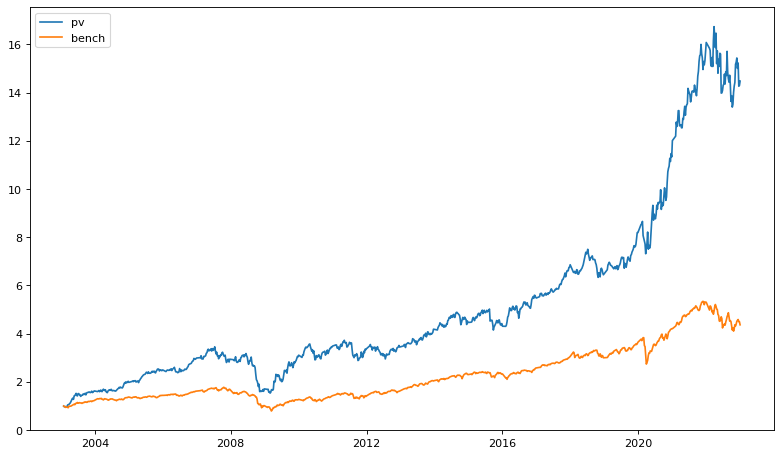

In [25]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [26]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,0.952314,0.980080,...,1.000000,1.000000,1.000000,2003,5,0.992184,878.680008,1.000000,2003-W5,2003-01-31
1,0.943463,0.897289,1.061107,0.996342,0.920759,0.969079,1.057864,0.986071,0.928278,0.821334,...,0.968007,0.985642,0.970210,2003,6,0.965586,854.137988,0.972069,2003-W6,2003-02-07
2,0.928368,0.916711,1.101357,1.054288,0.953710,1.004300,1.047603,0.999391,0.948282,0.808389,...,0.954507,0.967451,0.996888,2003,7,0.972693,843.990014,0.960520,2003-W7,2003-02-14
3,0.927734,0.914125,1.089655,1.089788,0.974227,1.038826,1.047603,1.082347,0.975463,0.822589,...,0.981717,0.988636,0.982491,2003,8,0.975150,827.221997,0.941437,2003-W8,2003-02-21
4,0.933063,0.952144,1.065174,1.100244,0.979701,1.032153,1.015778,1.060581,0.947648,0.823809,...,0.894498,1.058108,0.981060,2003,9,0.970637,845.392487,0.962116,2003-W9,2003-02-28
5,0.910269,0.902644,1.080724,1.133542,0.957397,0.986032,0.974920,1.054638,0.933597,0.778769,...,0.928288,1.152958,0.894678,2003,10,0.948870,835.426013,0.950774,2003-W10,2003-03-07
6,1.029151,1.023141,1.338512,1.244161,1.050161,1.192781,1.028284,1.108581,1.091975,0.788293,...,1.046804,1.191268,0.932448,2003,11,1.042336,827.527991,0.941785,2003-W11,2003-03-14
7,1.453676,1.027726,1.114137,1.225729,1.054551,1.224589,0.986597,1.126788,1.086537,0.778595,...,1.087927,1.192518,0.911762,2003,12,1.053421,815.514001,0.928113,2003-W12,2003-03-21
8,1.584835,1.026209,1.200148,1.291797,1.053178,1.291760,0.969788,1.137345,1.113200,0.747822,...,1.119282,1.139339,0.890317,2003,13,1.065373,874.943994,0.995748,2003-W13,2003-03-28
9,1.686813,1.128830,1.209436,1.345250,1.029811,1.302644,0.951175,1.101830,1.113200,0.745010,...,1.124217,1.147988,0.899201,2003,14,1.092971,868.188000,0.988059,2003-W14,2003-04-04


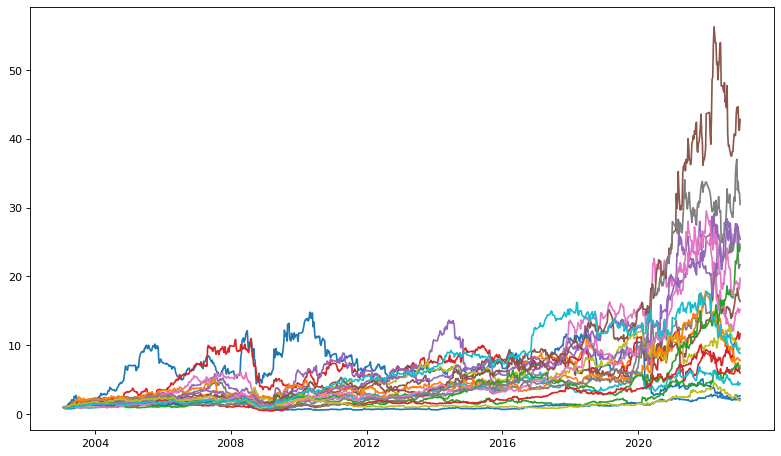

In [27]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [28]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Materials,2012.514913,28.207349,0.027425,1.0,1.003146,46.098067
Communication Services,2013.478248,28.641010,0.030572,1.0,1.003113,40.609370
Real Estate,2012.077009,27.961775,0.025158,1.0,1.003027,47.095655
Industrials,2012.410654,28.454662,0.026760,1.0,1.002883,47.813331
Energy,2012.661241,27.769576,0.031774,1.0,1.002796,39.922818
Information Technology,2013.362908,28.635987,0.031239,1.0,1.002773,43.051962
Consumer Discretionary,2012.685819,28.620361,0.040723,1.0,1.002716,38.441434
Health Care,2012.534865,28.959598,0.026959,1.0,1.002428,43.956522
Financials,2012.329070,28.790913,0.026514,1.0,1.002024,47.905490


In [29]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,weekly_delta,weekly_delta_sign,actual_returns,position
year,week,ticker,Security,,,,
2007,26,JCI,Johnson Controls,0.004092,1.0,4.221513,25
2008,42,UAL,United Airlines Holdings,0.083907,1.0,1.935484,30
2009,18,LVS,Las Vegas Sands,0.208342,1.0,1.624642,2
2020,5,TSLA,"Tesla, Inc.",0.003217,1.0,1.564756,17
2003,20,REGN,Regeneron,0.036379,1.0,1.500000,72
2013,19,TSLA,"Tesla, Inc.",0.113933,1.0,1.499550,1
2006,39,ALGN,Align Technology,0.049290,1.0,1.483660,8
2009,18,CBRE,CBRE Group,0.100423,1.0,1.455128,17
2020,7,ENPH,Enphase,0.060833,1.0,1.442763,2


In [30]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2003,5,0.980080,0.952314,1.000000,1.000000,1.000000,0.984134,1.005442,0.945833,1.011737,1.000000,1.000000
1,4012009,30,0.938524,0.925293,0.962803,0.995124,0.971937,0.980189,0.986373,0.951137,0.993073,0.980583,0.945143
2,8036054027,210,1.094703,0.919608,0.971920,0.968951,0.996076,0.971351,0.999122,0.987605,1.010165,0.995404,0.956431
3,16096216216081,1680,1.086413,0.917510,0.947319,0.991597,0.988083,0.975589,0.978708,0.984639,0.998320,1.000366,0.970563
4,32240721080810243,15120,1.120859,0.896412,0.932726,1.002740,0.987984,0.976330,0.968161,0.978314,0.972834,1.011106,0.949389
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,17.677598,11.033499,15.975786,6.830842,6.229438,10.660578,16.798063,13.838650,11.839538,10.079601,3.928498
952,0,0,18.339631,11.191219,16.241469,6.830842,6.241941,11.001682,16.795169,14.455021,12.087118,10.104334,4.017861
953,0,0,16.391634,10.455208,15.930435,6.830842,5.894068,10.440376,15.855184,13.307848,11.347591,9.558132,3.877038
954,0,0,16.521023,10.510768,15.930435,6.830842,5.985747,10.635654,15.862763,13.207554,11.347591,9.558132,3.877038
